# Retrieval Augmented Generation


## Setup


In [1]:
%pip install -U llama-index
%pip install -U llama-index-embeddings-huggingface
%pip install -U pinecone
%pip install -U llama-index-vector-stores-pinecone
%pip install -U deepeval
%pip install -U llama-index-llms-anthropic
%pip install llama-index-llms-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.2/853.2 kB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_n

In [2]:
import os

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.core import VectorStoreIndex
import numpy as np
import json
from llama_index.core.schema import TextNode
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.vector_stores.pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from google.colab import userdata
from llama_index.llms.openai import OpenAI


PINECONE_API_KEY = userdata.get("PINECONE_API_KEY")
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
ANTHROPIC_API_KEY = userdata.get("ANTHROPIC_API_KEY")
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")

In [3]:
!git clone https://$GITHUB_TOKEN@github.com/J-Gann/medfluencer.git

Cloning into 'medfluencer'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 145 (delta 62), reused 79 (delta 16), pack-reused 0
Receiving objects: 100% (145/145), 16.63 MiB | 6.61 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Updating files: 100% (42/42), done.
Filtering content: 100% (32/32), 13.66 GiB | 34.57 MiB/s, done.


In [3]:
embed_model = HuggingFaceEmbedding(
    model_name="T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
)

In [4]:
llm = Anthropic(
    model="claude-3-5-sonnet-20240620",
    api_key=ANTHROPIC_API_KEY,
    max_tokens=4096,
)

In [5]:
pc = Pinecone(api_key=PINECONE_API_KEY)

pinecone_index = pc.Index("medfluencer-videos-index-t-systems")
vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
index_videos = VectorStoreIndex.from_vector_store(vector_store, embed_model=embed_model)

pinecone_index = pc.Index("medfluencer-comments-index-t-systems")
vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
index_comments = VectorStoreIndex.from_vector_store(
    vector_store, embed_model=embed_model
)

pinecone_index = pc.Index("medfluencer-comments-extended-index-t-systems")
vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
index_comments_extended = VectorStoreIndex.from_vector_store(
    vector_store, embed_model=embed_model
)

#### Retriever


In [6]:
retriever_videos = VectorIndexRetriever(
    index=index_videos,
    similarity_top_k=20,
)

In [7]:
retriever_comments = VectorIndexRetriever(
    index=index_comments,
    similarity_top_k=20,
)

In [8]:
retriever_comments_extended = VectorIndexRetriever(
    index=index_comments_extended,
    similarity_top_k=150,
)

### Reranking


In [9]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank = SentenceTransformerRerank(
    model="cross-encoder/msmarco-MiniLM-L6-en-de-v1", top_n=5
)

rerank_comments_extended = SentenceTransformerRerank(
    model="cross-encoder/msmarco-MiniLM-L6-en-de-v1", top_n=5
)

### Query Engine


In [10]:
from llama_index.core import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine

In [11]:
response_synthesizer = get_response_synthesizer(llm=llm)

query_engine_videos = RetrieverQueryEngine(
    retriever=retriever_videos,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[rerank],
)

query_engine_comments = RetrieverQueryEngine(
    retriever=retriever_comments,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[rerank],
)

query_engine_comments_extended = RetrieverQueryEngine(
    retriever=retriever_comments_extended,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[rerank_comments_extended],
)

# Evaluation Videos


In [12]:
import json

#### Generate questions


In [ ]:
with open("medfluencer/medical_fields.json", "r", encoding="UTF-8") as file:
    medical_fields = json.load(file)

In [13]:
from collections import defaultdict

In [ ]:
# Generates questions for each medical field
#
# llm_questions = Anthropic(
#     model="claude-3-5-sonnet-20240620",
#     api_key=ANTHROPIC_API_KEY,
#     max_tokens=4096,
#     temperature=1,
# )
#
# field_questions = defaultdict(list)
# num_questions = 5
# for field in medical_fields:
#    for _ in range(num_questions):
#        question = llm_questions.complete(
#            f"Generiere eine medizinische Frage eines Laiens, die medizinischem Personal (Arthelferin, Arzt) typischerweise in folgenden Fachbereich gestellt wird: {field}\n Antworte ausschließlich mit der Frage!"
#        ).text
#        field_questions[field].append(question)
# with open("evaluation/questions_per_field.json", "w") as file:
#    json.dump(field_questions, file)

In [ ]:
with open("medfluencer/evaluation/questions_per_field.json", "r") as file:
    field_questions = json.load(file)

In [ ]:
# answers_per_field = defaultdict(list)
# for field, questions in field_questions.items():
#    for question in questions:
#        res = query_engine_videos.query(question)
#        answer = res.response
#        context = [node.text for node in res.source_nodes]
#        answers_per_field[field].append((answer, context))
# with open("evaluation/answers_per_field.json", "w") as file:
#    json.dump(answers_per_field, file)

In [ ]:
with open("medfluencer/evaluation/answers_per_field.json", "r") as file:
    answers_per_field = json.load(file)

#### DeepEval


In [ ]:
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    HallucinationMetric,
)
from deepeval.test_case import LLMTestCase

In [ ]:
test_cases_per_field = defaultdict(list)

for field, questions in field_questions.items():
    for idx, question in enumerate(questions):
        actual_output, retrieval_context = answers_per_field[field][idx]
        test_case = LLMTestCase(
            input=question,
            actual_output=actual_output,
            retrieval_context=retrieval_context,
            context=retrieval_context,
        )

        test_cases_per_field[field].append(test_case)

In [ ]:
len(list(test_cases_per_field.keys())) * 10 * 4

2520

In [ ]:
from deepeval.models.base_model import DeepEvalBaseLLM

class Claude(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = Anthropic(
            model="claude-3-5-sonnet-20240620",
            api_key=ANTHROPIC_API_KEY,
            max_tokens=4096,
        )

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "claude-3-5-sonnet-20240620"


class GPT4mini(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)


    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "gpt-4o-mini"

In [ ]:
# import pickle
#
# model = GPT4mini()
#
# answer_relevancy_metric = AnswerRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# faithfulness_metric = FaithfulnessMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# contextual_relevancy_metric = ContextualRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# hallucination_metric = HallucinationMetric(
#     threshold=0.5,
#     model=model,
#     include_reason=False
# )
#
# evaluations = {}
#
# for field, test_case in test_cases_per_field.items():
#
#     evaluation = evaluate(
#         test_case,
#         [
#             answer_relevancy_metric,
#             faithfulness_metric,
#             contextual_relevancy_metric,
#             hallucination_metric,
#         ],
#     )
#
#     evaluations[field] = evaluation
#
#     with open("medfluencer/evaluation/evaluation_metrics_rag.pkl", "wb") as file:
#         pickle.dump(evaluations, file)

In [ ]:
import pickle
with open("medfluencer/evaluation/evaluation_metrics_rag.pkl", "rb") as file:
    evaluation = pickle.load(file)

In [ ]:
answer_relevancy_metrics = defaultdict(list)
faithfulness_metrics = defaultdict(list)
contextual_relevancy_metrics = defaultdict(list)
hallucination_metrics = defaultdict(list)

for field, test_cases in evaluation.items():
    for test_case in [test_case.metrics_metadata for test_case in test_cases]:
        for metric in test_case:
            if metric.metric == "Answer Relevancy":
                answer_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Faithfulness":
                faithfulness_metrics[field].append(metric.score)
            elif metric.metric == "Contextual Relevancy":
                contextual_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Hallucination":
                hallucination_metrics[field].append(metric.score)


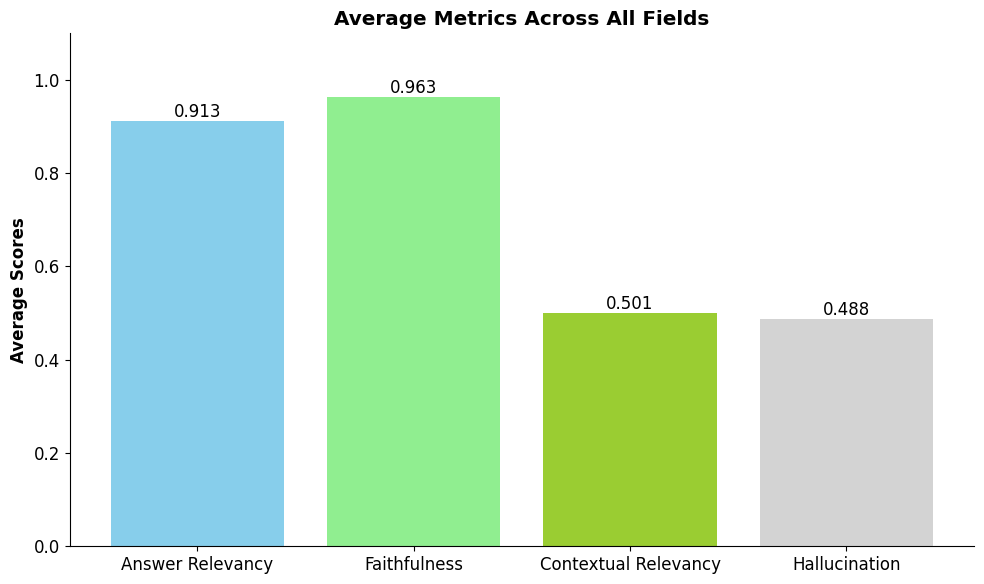

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

# Calculate averages across all fields
avg_answer_relevancy = np.mean([np.mean(answer_relevancy_metrics[field]) for field in evaluation.keys()])
avg_faithfulness = np.mean([np.mean(faithfulness_metrics[field]) for field in evaluation.keys()])
avg_contextual_relevancy = np.mean([np.mean(contextual_relevancy_metrics[field]) for field in evaluation.keys()])
avg_hallucination = np.mean([np.mean(hallucination_metrics[field]) for field in evaluation.keys()])

# Prepare data for plotting
labels = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Hallucination']
averages = [avg_answer_relevancy, avg_faithfulness, avg_contextual_relevancy, avg_hallucination]
colors = ['skyblue', 'lightgreen', 'yellowgreen', 'lightgrey']

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, averages, color=colors)

ax.set_ylabel('Average Scores', fontweight='bold')
ax.set_title('Average Metrics Across All Fields', fontweight='bold')
ax.set_ylim(0, 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()


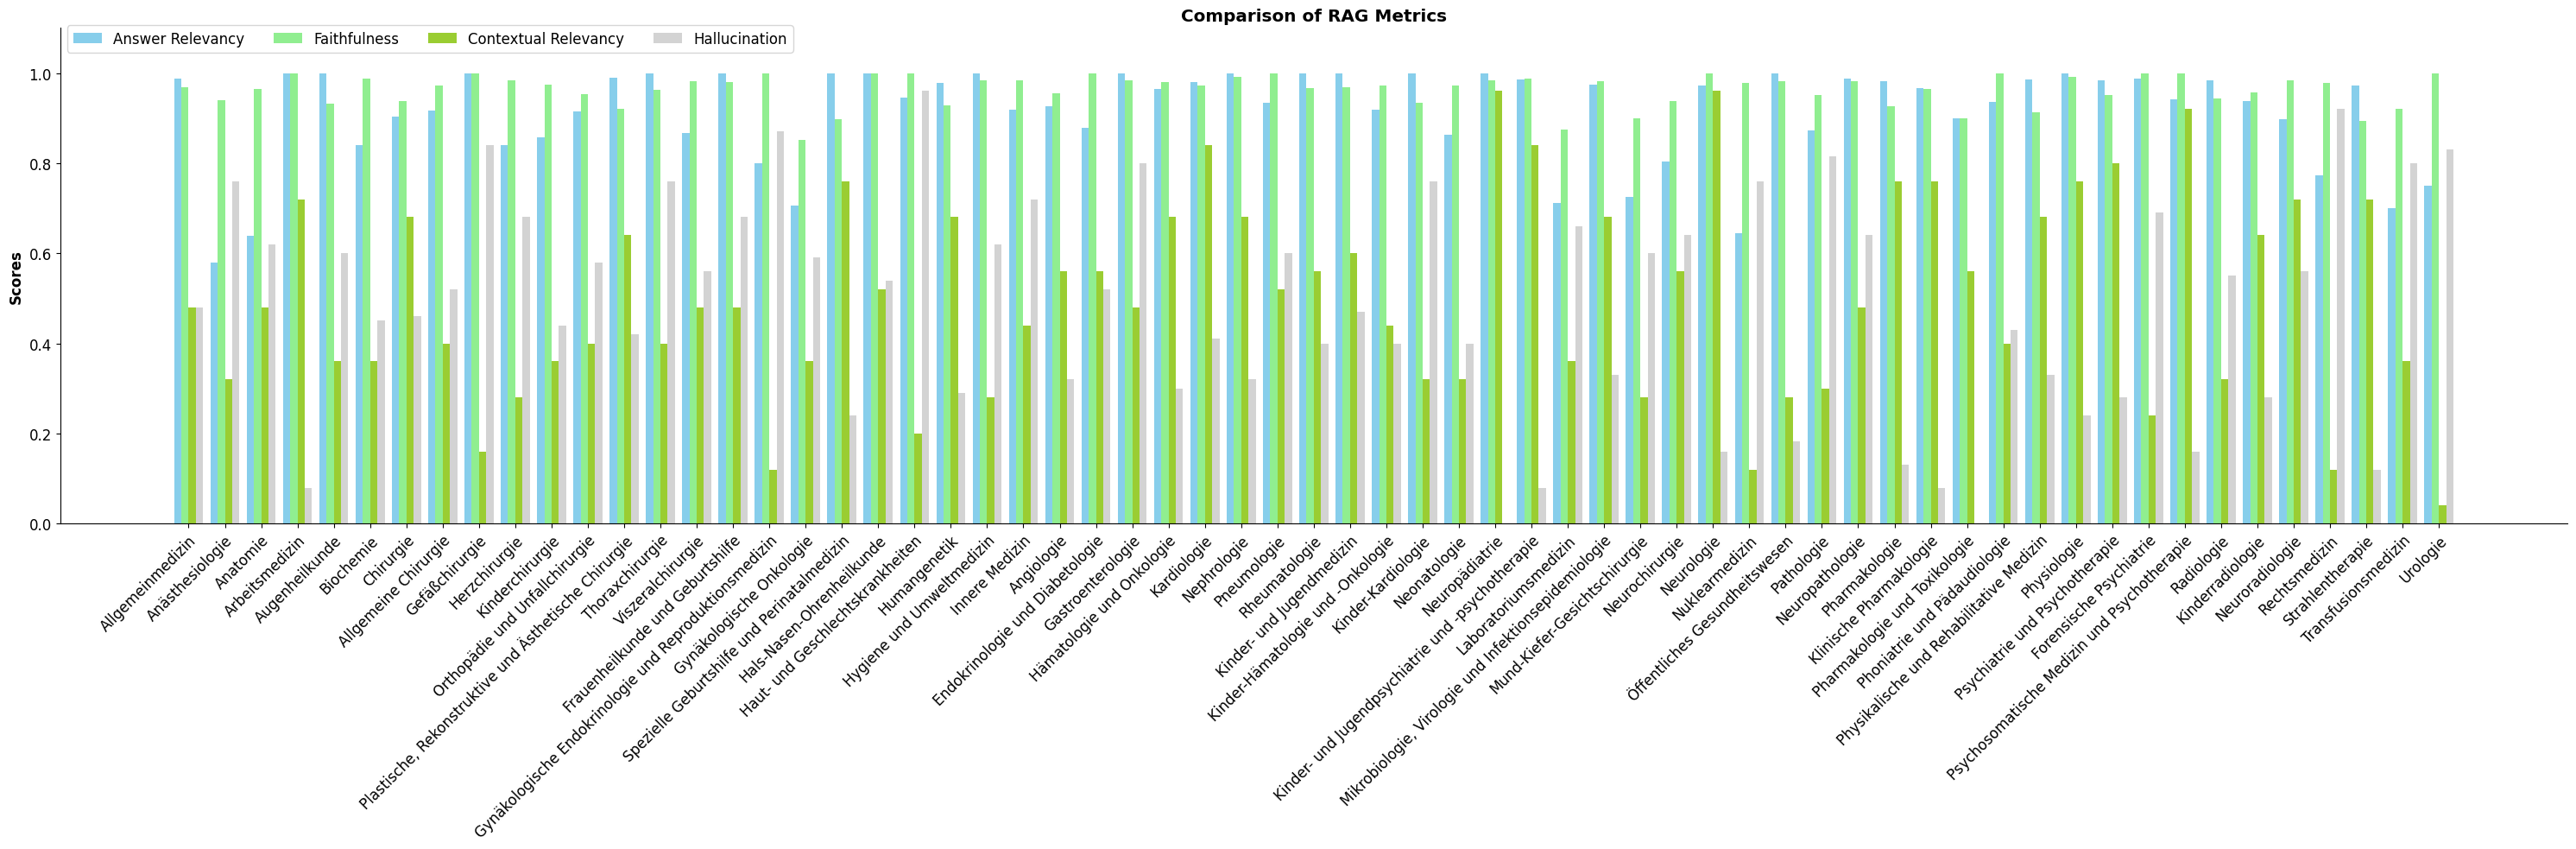

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps
gap = 0.05  # Small gap between groups

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

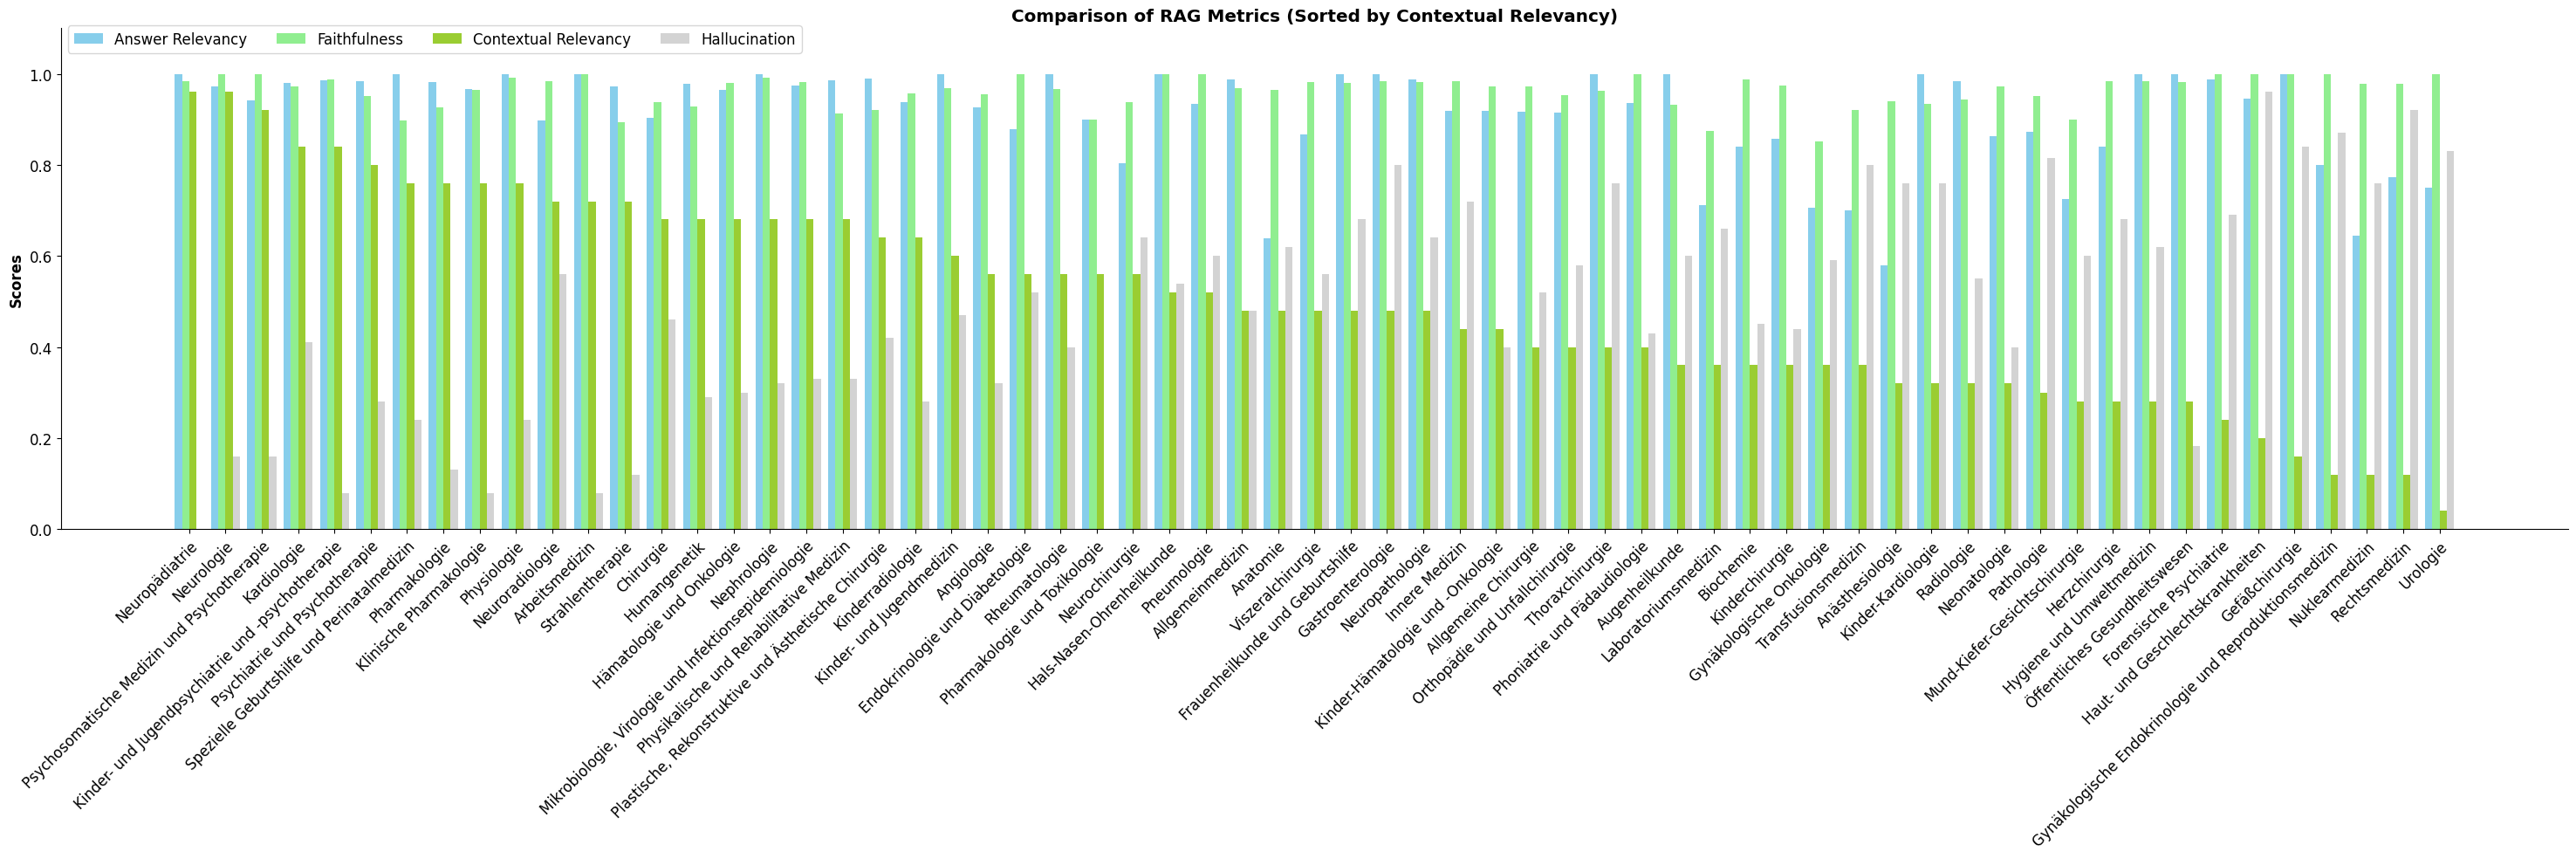

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

# Sort all lists based on contextual relevancy scores
sorted_indices = sorted(range(len(contextual_relevancy_metrics_means)),
                        key=lambda k: contextual_relevancy_metrics_means[k],
                        reverse=True)

labels = [labels[i] for i in sorted_indices]
answer_relevancy_metrics_means = [answer_relevancy_metrics_means[i] for i in sorted_indices]
faithfulness_metrics_means = [faithfulness_metrics_means[i] for i in sorted_indices]
contextual_relevancy_metrics_means = [contextual_relevancy_metrics_means[i] for i in sorted_indices]
hallucination_metrics_means = [hallucination_metrics_means[i] for i in sorted_indices]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics (Sorted by Contextual Relevancy)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

Observations:
- wide spread of contextual relevancy, probably because of differences in field frequency in dataset
- always quite good relevancy and faithfulness => relevant for answer and does not contradict context
- hallucination increases with lack of contextual relevancy but general relevancy reamins high => llm answers question based on internal knowledge and not provided context

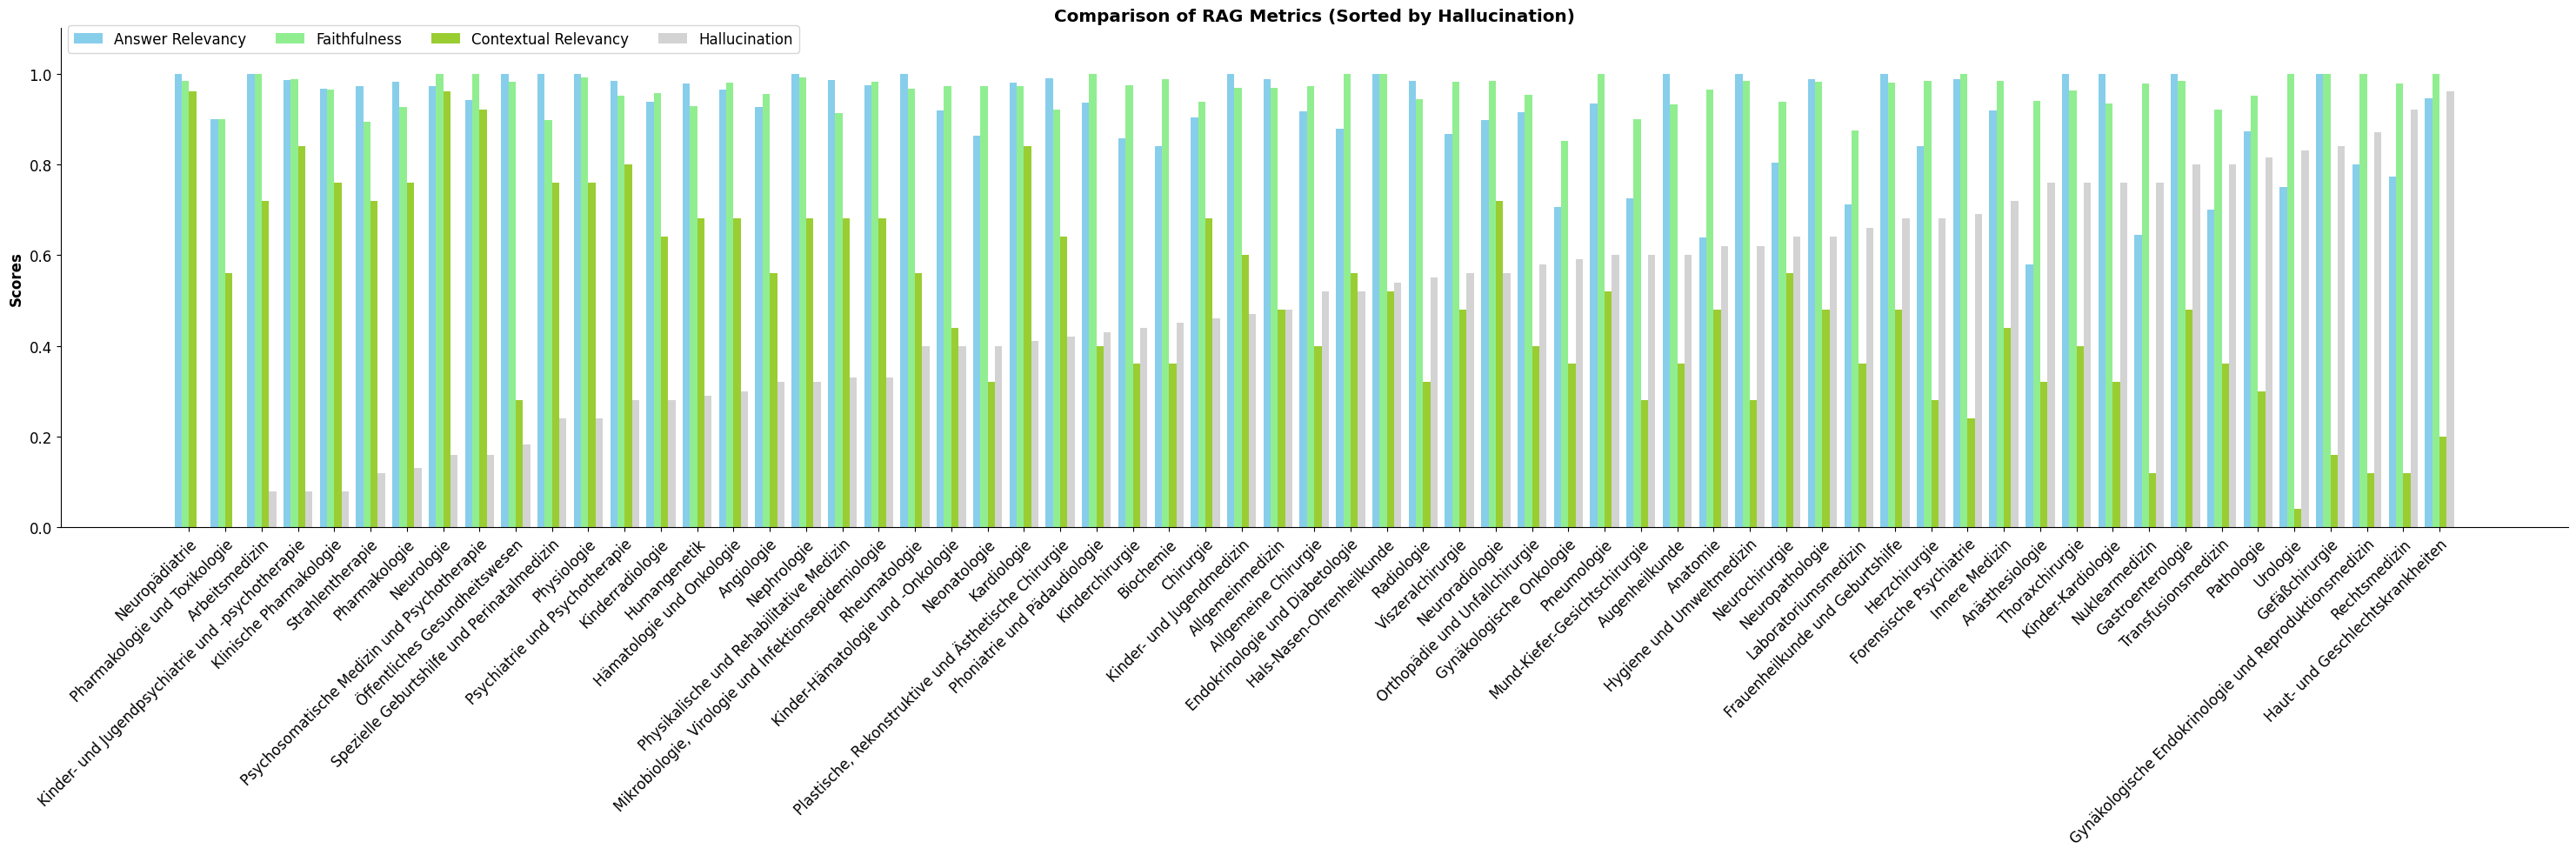

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

# Sort all lists based on hallucination scores
sorted_indices = sorted(range(len(hallucination_metrics_means)),
                        key=lambda k: hallucination_metrics_means[k],
                        reverse=False)

labels = [labels[i] for i in sorted_indices]
answer_relevancy_metrics_means = [answer_relevancy_metrics_means[i] for i in sorted_indices]
faithfulness_metrics_means = [faithfulness_metrics_means[i] for i in sorted_indices]
contextual_relevancy_metrics_means = [contextual_relevancy_metrics_means[i] for i in sorted_indices]
hallucination_metrics_means = [hallucination_metrics_means[i] for i in sorted_indices]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics (Sorted by Hallucination)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

TODO: generate question and answer pairs from dataset to check if RAG can answer correctly in cases where the data is available
https://docs.llamaindex.ai/en/stable/module_guides/evaluating/evaluating_with_llamadatasets/

# Evaluation Comments

In [ ]:
# Generates questions for each medical field

# from collections import defaultdict
#
# llm_questions = OpenAI(
#     model="gpt-4o-mini",
#     api_key=OPENAI_API_KEY,
#     temperature=1
# )
#
# field_questions_comments = defaultdict(list)
#
# num_questions = 5
# for field in medical_fields:
#     for _ in range(num_questions):
#         question = llm_questions.complete(
#             f"Generiere eine medizinische Frage eines Laien, nach Erfahrungsberichten in {field}.\n Antworte ausschließlich mit der Frage!"
#         ).text
#         field_questions_comments[field].append(question)
#         print(question)
#
# with open("medfluencer/evaluation/questions_per_field_comments.json", "w") as file:
#     json.dump(field_questions_comments, file)
#

Warum habe ich ständig Kopfschmerzen, obwohl ich genug Wasser trinke und regelmäßig schlafe?
Wie kann ich sicherstellen, dass ich die richtige Dosis meiner verschriebenen Medikamente einnehme?
Welche Erfahrungen haben andere Patienten gemacht, als sie wegen anhaltender Müdigkeit und Erschöpfung einen Allgemeinarzt aufgesucht haben?
Warum habe ich das Gefühl, dass meine Beschwerden nicht ernst genommen werden, obwohl ich mehrere Arztbesuche hinter mir habe?
Warum habe ich ständig Kopfschmerzen, und wann sollte ich mir Sorgen machen?
Wie sicher ist die Vollnarkose bei Routineoperationen und gibt es Erfahrungen, die das Risiko von Komplikationen während oder nach dem Eingriff betreffen?
Wie erlebt man die Narkose im Operationssaal und gibt es Risiken oder unangenehme Erfahrungen, die Patienten berichten?
Wie sicher ist die Anästhesie während einer Operation und welche Risiken sollten Patienten dabei beachten?
Welche Erfahrungen haben Menschen gemacht, die sich einer Narkose unterziehen mu

Beobachtungen:
- können anhand der Kommentare Statistische Erhebungen durchgeführt werden? => sehr große Anzahl an kommentaren retrieven und durch rag auswerten?

In [ ]:
with open("medfluencer/evaluation/questions_per_field_comments.json", "r") as file:
    field_questions_comments = json.load(file)

In [ ]:
# answers_per_field = defaultdict(list)
# for field, questions in field_questions_comments.items():
#    for question in questions:
#        res = query_engine_comments.query(question)
#        answer = res.response
#        context = [node.text for node in res.source_nodes]
#        answers_per_field[field].append((answer, context))
#        print(answer)
#
# with open("medfluencer/evaluation/answers_per_field_comments.json", "w") as file:
#     json.dump(answers_per_field, file)

Es gibt mehrere mögliche Gründe für Ihre anhaltenden Kopfschmerzen, auch wenn Sie ausreichend Wasser trinken und regelmäßig schlafen:

1. Krankheit: Wenn Sie momentan krank sind, können Kopfschmerzen ein Symptom dieser Erkrankung sein.

2. Ernährung: Eine unausgewogene Ernährung oder zu wenig Nahrungsaufnahme aufgrund von Übelkeit kann Kopfschmerzen verursachen.

3. Koffein: Falls Sie Koffein konsumieren, kann dies zur Dehydrierung beitragen und Kopfschmerzen verstärken.

4. Stress oder Anspannung: Emotionale oder körperliche Belastungen können Kopfschmerzen auslösen.

5. Körperhaltung: Wenn Sie längere Zeit liegen müssen, kann eine ungünstige Körperhaltung zu Verspannungen und Kopfschmerzen führen.

6. Überhydrierung: Zu viel Flüssigkeitsaufnahme kann ebenfalls Probleme verursachen.

7. Schlafqualität: Obwohl Sie regelmäßig schlafen, könnte die Qualität Ihres Schlafes beeinträchtigt sein.

Es wäre ratsam, einen Arzt aufzusuchen, um die genaue Ursache Ihrer Kopfschmerzen zu ermitteln u

FileNotFoundError: [Errno 2] No such file or directory: 'evaluation/answers_per_field_comments.json'

In [ ]:
with open("medfluencer/evaluation/answers_per_field_comments.json", "r") as file:
    answers_per_field = json.load(file)

In [ ]:
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    HallucinationMetric,
)
from deepeval.test_case import LLMTestCase

/usr/local/lib/python3.10/dist-packages/deepeval/__init__.py:45: UserWarning: You are using deepeval version 0.21.68, however version 0.21.71 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [ ]:
test_cases_per_field = defaultdict(list)

for field, questions in field_questions_comments.items():
    for idx, question in enumerate(questions):
        actual_output, retrieval_context = answers_per_field[field][idx]
        test_case = LLMTestCase(
            input=question,
            actual_output=actual_output,
            retrieval_context=retrieval_context,
            context=retrieval_context,
        )

        test_cases_per_field[field].append(test_case)

In [ ]:
len(list(test_cases_per_field.keys())) * 10 * 4

2520

In [ ]:
from deepeval.models.base_model import DeepEvalBaseLLM

class Claude(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = Anthropic(
            model="claude-3-5-sonnet-20240620",
            api_key=ANTHROPIC_API_KEY,
            max_tokens=4096,
        )

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "claude-3-5-sonnet-20240620"


class GPT4mini(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)


    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "gpt-4o-mini"

In [ ]:
# import pickle
#
# model = GPT4mini()
#
# answer_relevancy_metric = AnswerRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# faithfulness_metric = FaithfulnessMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# contextual_relevancy_metric = ContextualRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# hallucination_metric = HallucinationMetric(
#     threshold=0.5,
#     model=model,
#     include_reason=False
# )
#
# evaluations = {}
#
# for field, test_case in test_cases_per_field.items():
#     if field in evaluations: continue
#     evaluation = evaluate(
#         test_case,
#         [
#             answer_relevancy_metric,
#             faithfulness_metric,
#             contextual_relevancy_metric,
#             hallucination_metric,
#         ],
#     )
#
#     evaluations[field] = evaluation
#
# with open("medfluencer/evaluation/evaluation_metrics_rag_comments.pkl", "wb") as file:
#     pickle.dump(evaluations, file)

Observation:
- RAG system retrieves comments which state the same question but not the corresponding answer => generate question answer pairs of comments beforehand?

In [ ]:
import pickle
with open("medfluencer/evaluation/evaluation_metrics_rag_comments.pkl", "rb") as file:
    evaluation = pickle.load(file)

In [ ]:
answer_relevancy_metrics = defaultdict(list)
faithfulness_metrics = defaultdict(list)
contextual_relevancy_metrics = defaultdict(list)
hallucination_metrics = defaultdict(list)

for field, test_cases in evaluation.items():
    for test_case in [test_case.metrics_metadata for test_case in test_cases]:
        for metric in test_case:
            if metric.metric == "Answer Relevancy":
                answer_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Faithfulness":
                faithfulness_metrics[field].append(metric.score)
            elif metric.metric == "Contextual Relevancy":
                contextual_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Hallucination":
                hallucination_metrics[field].append(metric.score)


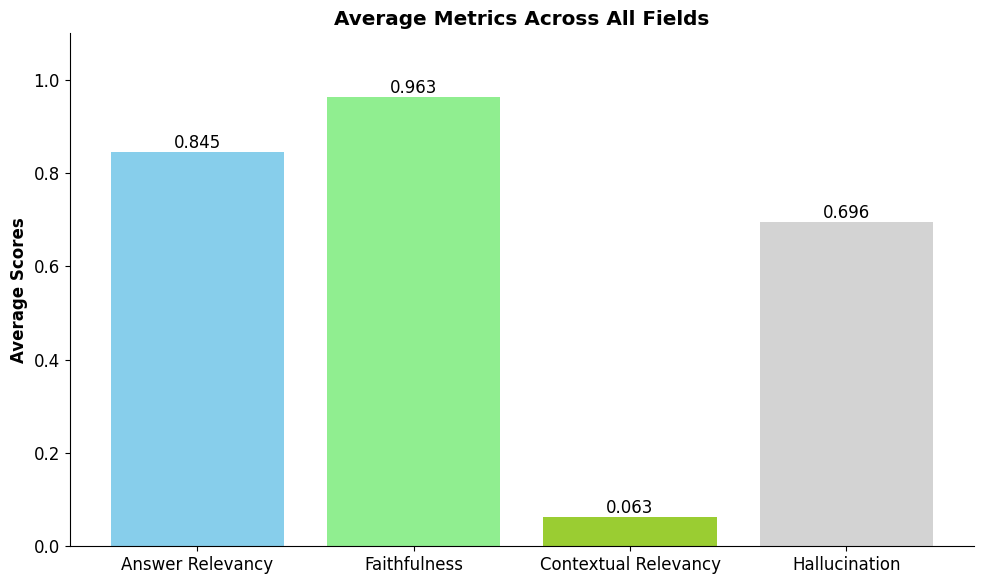

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

# Calculate averages across all fields
avg_answer_relevancy = np.mean([np.mean(answer_relevancy_metrics[field]) for field in evaluation.keys()])
avg_faithfulness = np.mean([np.mean(faithfulness_metrics[field]) for field in evaluation.keys()])
avg_contextual_relevancy = np.mean([np.mean(contextual_relevancy_metrics[field]) for field in evaluation.keys()])
avg_hallucination = np.mean([np.mean(hallucination_metrics[field]) for field in evaluation.keys()])

# Prepare data for plotting
labels = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Hallucination']
averages = [avg_answer_relevancy, avg_faithfulness, avg_contextual_relevancy, avg_hallucination]
colors = ['skyblue', 'lightgreen', 'yellowgreen', 'lightgrey']

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, averages, color=colors)

ax.set_ylabel('Average Scores', fontweight='bold')
ax.set_title('Average Metrics Across All Fields', fontweight='bold')
ax.set_ylim(0, 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()


# Evaluation Comments Extended

In [17]:
with open("medfluencer/evaluation/questions_per_field_comments.json", "r") as file:
    field_questions_comments = json.load(file)

In [16]:
from collections import defaultdict

In [36]:
# answers_per_field = defaultdict(list)
# for field, questions in field_questions_comments.items():
#    for question in questions:
#        res = query_engine_comments_extended.query(question)
#        answer = res.response
#        context = [node.text for node in res.source_nodes]
#        answers_per_field[field].append((answer, context))
#        print(answer)
#
# with open("medfluencer/evaluation/answers_per_field_comments_extended.json", "w") as file:
#     json.dump(answers_per_field, file)

Es gibt mehrere mögliche Gründe für anhaltende Kopfschmerzen, auch wenn Sie ausreichend Wasser trinken und regelmäßig schlafen. Einige Faktoren, die in Betracht gezogen werden sollten, sind:

1. Ernährung: Bestimmte Lebensmittel oder Getränke, insbesondere solche mit viel Zucker oder kurzkettigen Kohlenhydraten, können Kopfschmerzen auslösen.

2. Koffeinkonsum: Zu viel oder zu wenig Koffein kann Kopfschmerzen verursachen.

3. Stress und Anspannung: Emotionaler oder körperlicher Stress kann zu Kopfschmerzen führen.

4. Haltung und Ergonomie: Schlechte Körperhaltung, besonders bei der Arbeit am Computer, kann Verspannungen und Kopfschmerzen verursachen.

5. Umweltfaktoren: Lärm, helles Licht oder bestimmte Gerüche können Kopfschmerzen auslösen.

6. Medizinische Gründe: Es könnte auch eine zugrunde liegende medizinische Ursache geben, die von einem Arzt untersucht werden sollte.

Es ist ratsam, ein Tagebuch zu führen, um mögliche Auslöser zu identifizieren, und bei anhaltenden Beschwerden

In [14]:
with open("medfluencer/evaluation/answers_per_field_comments.json", "r") as file:
    answers_per_field = json.load(file)

In [15]:
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    HallucinationMetric,
)
from deepeval.test_case import LLMTestCase

In [18]:
test_cases_per_field = defaultdict(list)

for field, questions in field_questions_comments.items():
    for idx, question in enumerate(questions):
        actual_output, retrieval_context = answers_per_field[field][idx]
        test_case = LLMTestCase(
            input=question,
            actual_output=actual_output,
            retrieval_context=retrieval_context,
            context=retrieval_context,
        )

        test_cases_per_field[field].append(test_case)

In [19]:
len(list(test_cases_per_field.keys())) * 10 * 4

2520

In [20]:
from deepeval.models.base_model import DeepEvalBaseLLM

class Claude(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = Anthropic(
            model="claude-3-5-sonnet-20240620",
            api_key=ANTHROPIC_API_KEY,
            max_tokens=4096,
        )

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "claude-3-5-sonnet-20240620"


class GPT4mini(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)


    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "gpt-4o-mini"

In [21]:
import pickle
model = GPT4mini()
answer_relevancy_metric = AnswerRelevancyMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
faithfulness_metric = FaithfulnessMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
contextual_relevancy_metric = ContextualRelevancyMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
hallucination_metric = HallucinationMetric(
    threshold=0.5,
    model=model,
    include_reason=False
)
evaluations = {}
for field, test_case in test_cases_per_field.items():
    if field in evaluations: continue
    evaluation = evaluate(
        test_case,
        [
            answer_relevancy_metric,
            faithfulness_metric,
            contextual_relevancy_metric,
            hallucination_metric,
        ],
    )
    evaluations[field] = evaluation
    with open("medfluencer/evaluation/evaluation_metrics_rag_comments_extended.pkl", "wb") as file:
        pickle.dump(evaluations, file)

Output()

Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


KeyboardInterrupt: 

In [ ]:
import pickle
with open("medfluencer/evaluation/evaluation_metrics_rag_comments_extended.pkl", "rb") as file:
    evaluation = pickle.load(file)

In [ ]:
answer_relevancy_metrics = defaultdict(list)
faithfulness_metrics = defaultdict(list)
contextual_relevancy_metrics = defaultdict(list)
hallucination_metrics = defaultdict(list)

for field, test_cases in evaluation.items():
    for test_case in [test_case.metrics_metadata for test_case in test_cases]:
        for metric in test_case:
            if metric.metric == "Answer Relevancy":
                answer_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Faithfulness":
                faithfulness_metrics[field].append(metric.score)
            elif metric.metric == "Contextual Relevancy":
                contextual_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Hallucination":
                hallucination_metrics[field].append(metric.score)


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

# Calculate averages across all fields
avg_answer_relevancy = np.mean([np.mean(answer_relevancy_metrics[field]) for field in evaluation.keys()])
avg_faithfulness = np.mean([np.mean(faithfulness_metrics[field]) for field in evaluation.keys()])
avg_contextual_relevancy = np.mean([np.mean(contextual_relevancy_metrics[field]) for field in evaluation.keys()])
avg_hallucination = np.mean([np.mean(hallucination_metrics[field]) for field in evaluation.keys()])

# Prepare data for plotting
labels = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Hallucination']
averages = [avg_answer_relevancy, avg_faithfulness, avg_contextual_relevancy, avg_hallucination]
colors = ['skyblue', 'lightgreen', 'yellowgreen', 'lightgrey']

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, averages, color=colors)

ax.set_ylabel('Average Scores', fontweight='bold')
ax.set_title('Average Metrics Across All Fields', fontweight='bold')
ax.set_ylim(0, 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()
